In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

import matplotlib.pyplot as plt 
import matplotlib 
matplotlib.rcParams.update({'font.size': 24, 'font.family': 'Helvetica', 'text.usetex': False})
%matplotlib inline

from utils.models import MLP
from utils.trainer import train_MLP
from utils.data import create_xor_dataset
from utils.plotting import plot_var, plot_task_rep, plot_hidden_in, plot_hidden_out
from utils.constants import COLORS

import copy

## Repeated training on one contingency (positive outcomes)

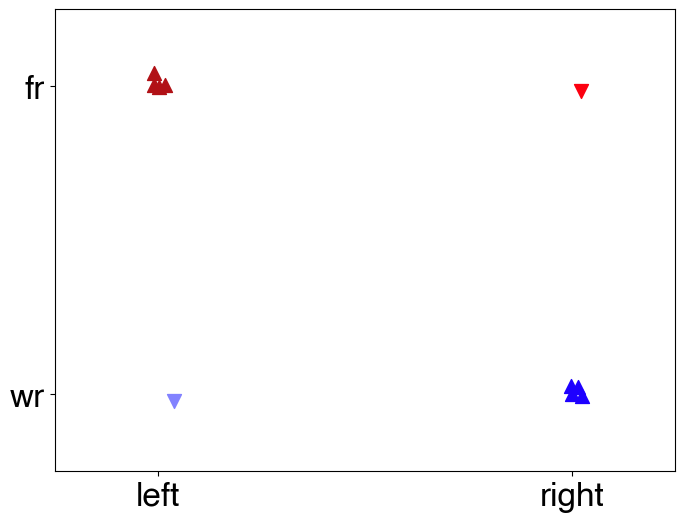

In [5]:
bev_bias_x1 = np.array ([-1., 1.] * 4 + [-1., 1.],  dtype = np.float32)
bev_bias_x2 = np.array ([1., -1.] * 4 + [-1., 1.], dtype = np.float32)
bev_bias_y_np  = np.array ([1., 1.] * 4 + [-1., -1.],dtype = np.float32)

bev_bias_X, bev_bias_y = create_xor_dataset(bev_bias_x1, bev_bias_x2, bev_bias_y_np, n_repeats=1, noise_lev=0.05)

fig, ax = plot_task_rep(bev_bias_X, bev_bias_y, colors=[COLORS['left_fr'], COLORS['right_wr']] * 4 + [COLORS['left_wr'], COLORS['right_fr']], marker_size=100)
fig.set_size_inches((8, 6))
# fig.savefig("bev_bias_inputs.svg")

In [6]:
n_runs = 20
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (0, 1)

lr = 2e-3  # Learning rate
# Initialization scale
w1_inits = [0.0025, 0.25]
w2_init = 1/dim_hidden

bev_bias_models = []
bev_bias_losses = np.zeros((len(w1_inits), n_runs, n_epochs))

# Training
for w_i, w1_init in enumerate(w1_inits):
    for r_i in range(n_runs):
        # Model instantiation
        dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
        loss_per_run, _ = train_MLP(dlnn_model, bev_bias_X, bev_bias_y, n_epochs=n_epochs, lr=lr)
        bev_bias_losses[w_i, r_i, :] = loss_per_run
        
    bev_bias_models.append(dlnn_model)

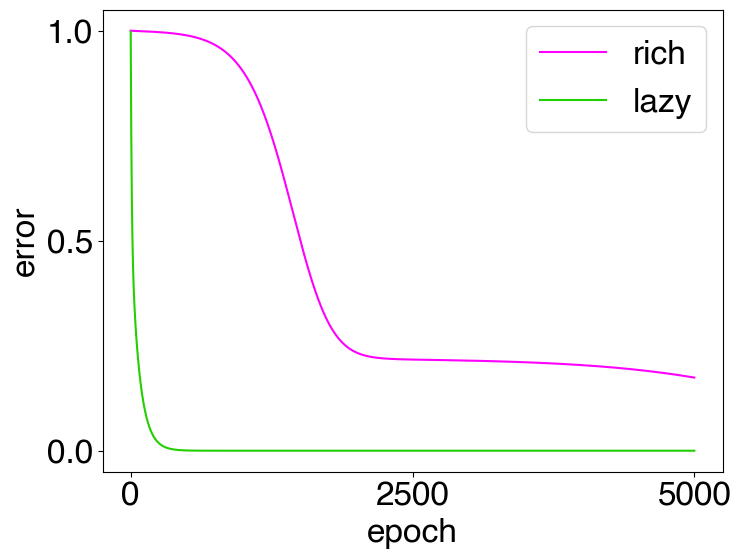

In [7]:
fig, ax = plot_var(bev_bias_losses, y_ticks=[0, 0.5, 1], fig_size=(8, 6))
# fig.savefig("bev_bias_loss.svg")

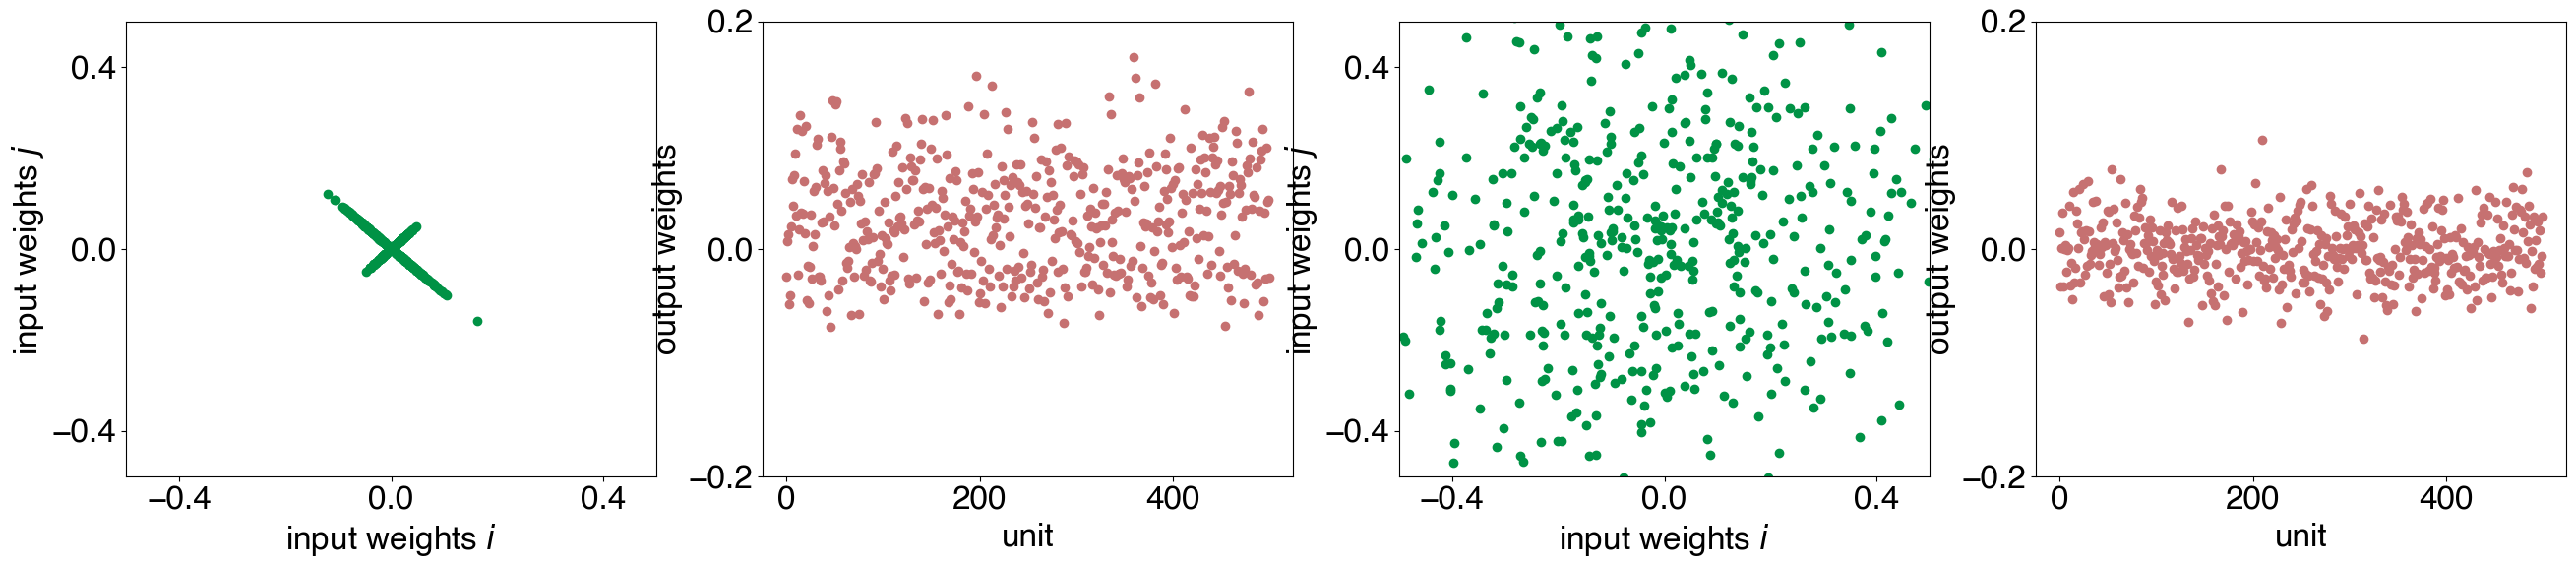

In [8]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(32, 6)

for m_i, model in enumerate(bev_bias_models):
    for p_i, (name, param) in enumerate(model.named_parameters()):
        fig_i = m_i*2 + p_i
        axis = axes[fig_i]
        
        if name == 'in_hid.weight':
            in_hid = param.detach().numpy()
            axis = plot_hidden_in(in_hid, axis)

        elif name == 'hid_out.weight':
            hid_out = param.detach().numpy()
            axis = plot_hidden_out(hid_out, axis)

# plt.savefig("rich_lazy_learning_bev_bias.svg")

## Replay of the other contingency (negative outcomes)

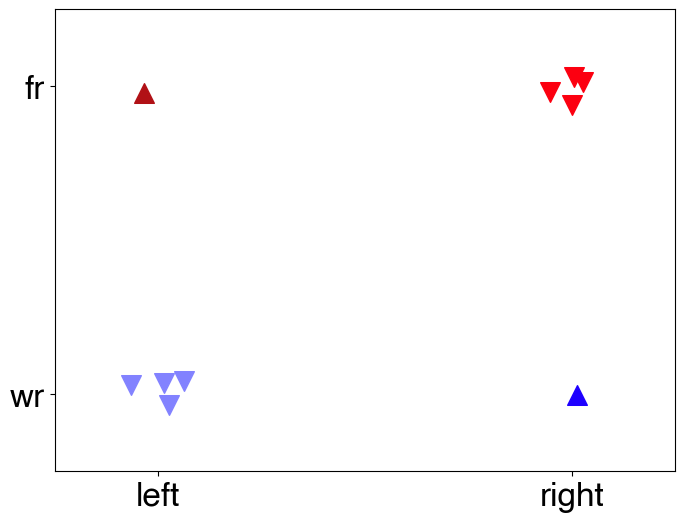

In [10]:
replay_bias_x1 = np.array ([1., -1.] * 4 + [1., -1.], dtype = np.float32)
replay_bias_x2 = np.array ([1., -1.] * 4 + [-1., 1.], dtype = np.float32)
replay_bias_y_np  = np.array ([-1., -1.] * 4 + [1., 1.],dtype = np.float32)

replay_bias_X, replay_bias_y = create_xor_dataset(replay_bias_x1, replay_bias_x2, replay_bias_y_np, n_repeats=1, noise_lev=0.05)

fig, ax = plot_task_rep(replay_bias_X, replay_bias_y, colors=[COLORS['right_fr'], COLORS['left_wr']] * 4 + [COLORS['right_wr'], COLORS['left_fr']])
fig.set_size_inches((8, 6))
# fig.savefig("replay_bias_inputs.svg")

In [26]:
replay_bias_models = []
replay_bias_losses = np.zeros((2, n_runs, n_epochs))
# Training
for m_i, bev_bias_model in enumerate(bev_bias_models):
    for r_i in range(n_runs):
        model = copy.deepcopy(bev_bias_model)
        loss_per_run, _ = train_MLP(model, replay_bias_X, replay_bias_y, n_epochs=n_epochs, lr=lr)
        replay_bias_losses[m_i, r_i, :] = loss_per_run
    replay_bias_models.append(model)

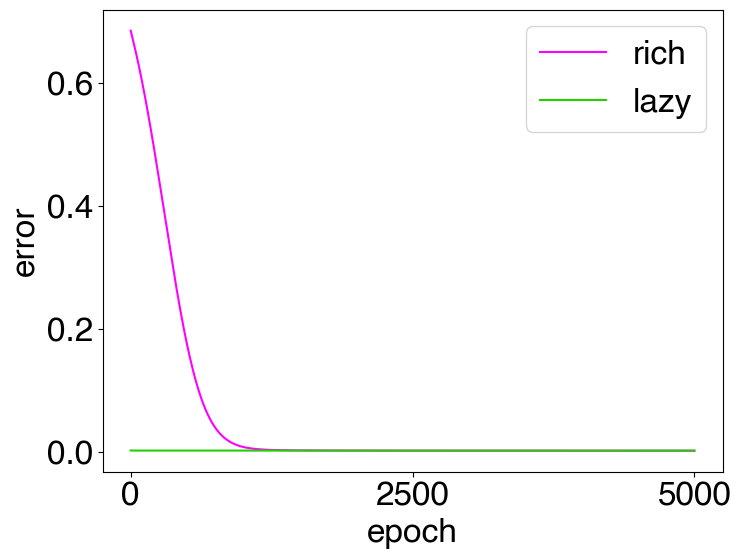

In [27]:
# Plotting losses after repeated training of one contingency
fig, ax = plot_var(replay_bias_losses, fig_size=(8, 6))
# fig.savefig("replay_bias_loss.svg")

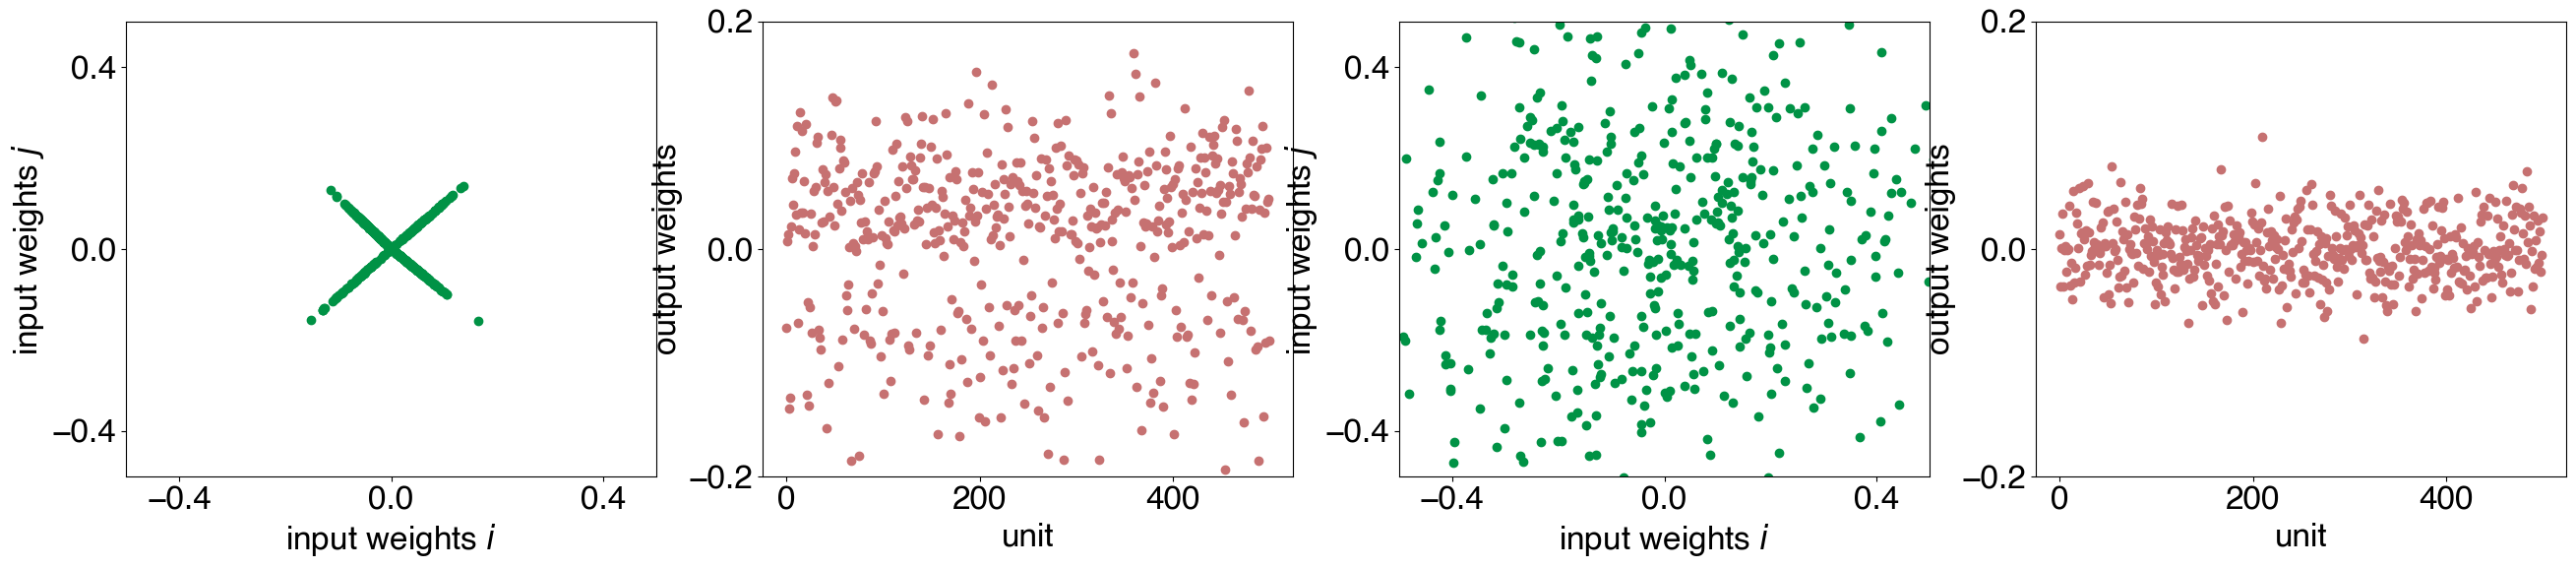

In [29]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(32, 6)

for m_i, model in enumerate(replay_bias_models):
    for p_i, (name, param) in enumerate(model.named_parameters()):
        fig_i = m_i*2 + p_i
        axis = axes[fig_i]
        
        if name == 'in_hid.weight':
            in_hid = param.detach().numpy()
            axis = plot_hidden_in(in_hid, axis)

        elif name == 'hid_out.weight':
            hid_out = param.detach().numpy()
            axis = plot_hidden_out(hid_out, axis)

# plt.savefig("rich_lazy_learning_replay_bias.svg")